In [2]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import copy
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from sklearn.model_selection import train_test_split

In [3]:
%matplotlib inline
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

# Read data 

In [4]:
df_labels = pd.read_csv("dataset/train.csv")
df_photo_to_biz = pd.read_csv("dataset/train_photo_to_biz_ids.csv")
df = df_photo_to_biz.join(other=df_labels.set_index('business_id'), how='left', on='business_id').drop(columns="business_id")

In [5]:
df_train = df_labels
df_train["photos_id"] = df_labels["business_id"].apply(lambda x: " ".join(map(str,df_photo_to_biz[df_photo_to_biz.business_id == x].photo_id.values)))

In [6]:
df_train.head()

,business_id,labels,photos_id
0,1000,1 2 3 4 5 6 7,438623 325966 227692 407856 368729 163193 2878...
1,1001,0 1 6 8,298536 20346 8457 308694 349310 407838 280304 ...
2,100,1 2 4 5 6 7,338465 328433 243861 361777 127198 466528 1592...
3,1006,1 2 4 5 6,46472 341947 396253 75316 42330 244095 171585 ...
4,1010,0 6 8,118251 219940 27517 8578 148347 433559 461006 ...


In [7]:
print(df_train.isnull().sum().sum())

4


In [8]:
df_train.dropna(inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [9]:
df_train.head()

,business_id,labels,photos_id
0,1000,1 2 3 4 5 6 7,438623 325966 227692 407856 368729 163193 2878...
1,1001,0 1 6 8,298536 20346 8457 308694 349310 407838 280304 ...
2,100,1 2 4 5 6 7,338465 328433 243861 361777 127198 466528 1592...
3,1006,1 2 4 5 6,46472 341947 396253 75316 42330 244095 171585 ...
4,1010,0 6 8,118251 219940 27517 8578 148347 433559 461006 ...


Business attributes, that corresponds to labels:

0: good_for_lunch

1: good_for_dinner

2: takes_reservations

3: outdoor_seating

4: restaurant_is_expensive

5: has_alcohol

6: has_table_service

7: ambience_is_classy

8: good_for_kids


In [10]:
labels_str = [
    "good for lunch", "good for dinner", "takes reservations",
    "outdoor seating", "restaurant is expensive", "has alcohol",
    "has table service", "ambience is classy", "good for kids"
]

In [11]:
LABELS_NUM = 9

In [12]:
def encode_label(l):
    res = np.zeros(LABELS_NUM)
    for i in l:
        res[i] = 1
    return res

train_L = np.vstack(df_train['labels'].apply(lambda x: tuple(sorted(int(t) for t in x.split()))).apply(encode_label))
df_train = pd.concat([df_train, pd.DataFrame(train_L)], axis=1).drop(columns=["labels"])
df_train.head()

,business_id,photos_id,0,1,2,3,4,5,6,7,8
0,1000,438623 325966 227692 407856 368729 163193 2878...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1001,298536 20346 8457 308694 349310 407838 280304 ...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,100,338465 328433 243861 361777 127198 466528 1592...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
3,1006,46472 341947 396253 75316 42330 244095 171585 ...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4,1010,118251 219940 27517 8578 148347 433559 461006 ...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [13]:
def show_image(opencv_image):
    b,g,r = cv2.split(opencv_image)
    rgb_image = cv2.merge([r,g,b])
    plt.imshow(rgb_image)
    plt.show()

In [14]:
def get_img(img_id):
    return cv2.resize(cv2.imread("dataset/train_photos/" + str(img_id) + ".jpg"), (299, 299), interpolation = cv2.INTER_LINEAR)

In [15]:
df_train.head()

,business_id,photos_id,0,1,2,3,4,5,6,7,8
0,1000,438623 325966 227692 407856 368729 163193 2878...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1001,298536 20346 8457 308694 349310 407838 280304 ...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,100,338465 328433 243861 361777 127198 466528 1592...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
3,1006,46472 341947 396253 75316 42330 244095 171585 ...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4,1010,118251 219940 27517 8578 148347 433559 461006 ...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


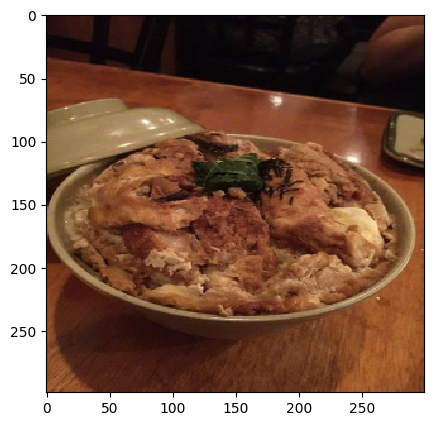

In [16]:
show_image(get_img(int(df.sample(1).photo_id)))

# Feature extraction

## Inception

In [17]:
from keras.applications import InceptionV3, ResNet50
from keras.applications.inception_v3 import preprocess_input as inception_preprocess
from keras.applications.resnet50 import preprocess_input as resnet_preprocess
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten

Using TensorFlow backend.


In [18]:
from operator import methodcaller

In [19]:
def get_images(df):
    return list(
        map(lambda x: list(map(get_img, x)),
            map(methodcaller("split", " "), df["photos_id"])))

In [20]:
def modify_model(original_model):
    original_model.layers.pop()
    bottleneck_model = Model(inputs=original_model.inputs, outputs=original_model.layers[-1].output)

    for layer in bottleneck_model.layers:
        layer.trainable = False

    return bottleneck_model

In [21]:
%%script false
def get_feature(model, preprocess, img):
    return model.predict(preprocess(np.expand_dims(image.img_to_array(img), axis=0)))
    
inception_model = modify_model(InceptionV3(weights='imagenet'))
df_train["inception_feature"] = 0 
resnet_model = modify_model(ResNet50(weights='imagenet'))
df_train["resnet_feature"] = 0 

cur_df = df_train
for ind in range(len(cur_df)):
    imgs = get_images(cur_df.iloc[ind:ind+1])[0]
    inception_features = list(map(lambda x: get_feature(inception_model, inception_preprocess, x), imgs))
    resnet_features = list(map(lambda x: get_feature(resnet_model, resnet_preprocess, x), imgs))

    inception_feature = np.array(features).mean(axis=0)
    cur_df.iloc[ind, -1] = feature.flatten().tostring()


with open("result.csv", "w") as f:
    f.write(df_train.to_csv())

CalledProcessError: Command 'b'def get_feature(model, preprocess, img):\n    return model.predict(preprocess(np.expand_dims(image.img_to_array(img), axis=0)))\n    \ninception_model = modify_model(InceptionV3(weights=\'imagenet\'))\ndf_train["inception_feature"] = 0 \nresnet_model = modify_model(ResNet50(weights=\'imagenet\'))\ndf_train["resnet_feature"] = 0 \n\ncur_df = df_train\nfor ind in range(len(cur_df)):\n    imgs = get_images(cur_df.iloc[ind:ind+1])[0]\n    inception_features = list(map(lambda x: get_feature(inception_model, inception_preprocess, x), imgs))\n    resnet_features = list(map(lambda x: get_feature(resnet_model, resnet_preprocess, x), imgs))\n\n    inception_feature = np.array(features).mean(axis=0)\n    cur_df.iloc[ind, -1] = feature.flatten().tostring()\n\n\nwith open("result.csv", "w") as f:\n    f.write(df_train.to_csv())\n'' returned non-zero exit status 1.

In [27]:
df = pd.read_csv("result_inception.csv", index_col='Unnamed: 0')
df_RES = pd.read_csv("result_resnet.csv", index_col = "Unnamed: 0")
df["resnet_feature"] = df_RES["resnet_feature"]

inception_df = pd.DataFrame(
    np.vstack(df["inception_feature"].apply(
        lambda x: np.fromstring(eval(x), dtype=np.float32))))

res_df = pd.DataFrame(
    np.vstack(df["resnet_feature"].apply(
        lambda x: np.fromstring(eval(x), dtype=np.float32))))
inception_df.columns = ["inception_" + str(col) for col in inception_df.columns]
res_df.columns = ["resnet_" + str(col) for col in res_df.columns]
df = pd.concat([df, inception_df, res_df], axis=1).drop(columns=["photos_id"])
df

,business_id,0,1,2,3,4,5,6,7,8,...,resnet_2038,resnet_2039,resnet_2040,resnet_2041,resnet_2042,resnet_2043,resnet_2044,resnet_2045,resnet_2046,resnet_2047
0,1000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.187016,0.404668,0.745854,0.058749,0.159665,0.591188,0.326503,0.287304,0.316530,0.516785
1,1001,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.136995,0.266796,1.110123,0.124553,0.349828,0.529303,0.485047,0.231563,0.605598,1.049986
2,100,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.237757,0.404514,0.443080,0.110313,0.277176,0.621667,0.209450,0.207121,0.303427,0.758990
3,1006,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.282736,0.307726,0.438247,0.032193,0.128639,1.089945,0.296704,0.143280,0.283848,1.422482
4,1010,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.692112,0.295000,0.416192,0.053243,0.430959,1.095836,0.261012,0.123595,0.233354,0.797160
5,101,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.342189,0.351933,0.349491,0.063517,0.202441,0.649596,0.303163,0.234317,0.289006,0.801488
6,1011,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.291209,0.394500,0.488594,0.052000,0.227836,0.827535,0.543772,0.107874,0.206551,1.345996
7,1012,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.282357,0.368493,0.593689,0.275064,0.319735,0.617776,0.419706,0.147207,0.343376,1.434756
8,1014,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.246185,0.398678,0.534019,0.060403,0.222002,0.738451,0.332816,0.155495,0.265355,1.010262
9,1015,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.151535,0.473618,0.746908,0.160791,0.289076,0.619311,0.254485,0.153181,0.343250,0.822365


## Fisher vector

In [28]:
from sklearn.mixture import GaussianMixture

In [29]:
def fisher_vector(xx, gmm):
    xx = np.atleast_2d(xx)
    N = xx.shape[0]

    # Compute posterior probabilities.
    Q = gmm.predict_proba(xx)  # NxK

    # Compute the sufficient statistics of descriptors.
    Q_sum = np.sum(Q, 0)[:, np.newaxis] / N
    Q_xx = np.dot(Q.T, xx) / N
    Q_xx_2 = np.dot(Q.T, xx ** 2) / N

    # Compute derivatives with respect to mixing weights, means and variances.
    d_pi = Q_sum.squeeze() - gmm.weights_
    d_mu = Q_xx - Q_sum * gmm.means_
    d_sigma = (
        - Q_xx_2
        - Q_sum * gmm.means_ ** 2
        + Q_sum * gmm.covariances_
        + 2 * Q_xx * gmm.means_)

    # Merge derivatives into a vector.
    return np.hstack((d_pi, d_mu.flatten(), d_sigma.flatten()))


In [30]:
def grid_search_GMM(X, K=16):
    lowest_bic = np.inf
    bic = []
    n_components_range = range(1, K)
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type='diag', random_state=42)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
    print(best_gmm)
    return best_gmm

In [84]:
gmm = grid_search_GMM(df.iloc[:, -2048:], 64)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=13, n_init=1,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)


In [87]:
print(fisher_vector(df.iloc[0, -2048:], gmm))
print(len(fisher_vector(df.iloc[0, -2048:], gmm)))

[-0.10222702392589418 0.9178356212948553 -0.07014173880281319 ... 0.0 0.0
 0.0]
53261


## VLAD Descriptor

In [88]:
from Vlad import Vlad

In [90]:
vlad = Vlad(16)
vlad.fit(df.iloc[:, -2048:].values)

Vlad(dimension_ordering='tf', inner_batch=128, n_codewords=16, normalization=3)

In [92]:
vlad_features = vlad.transform(df.iloc[:, -2048:].values)
vlad_features

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.01581753,
        -0.01266471, -0.04072613]])

# Data investigating

## Class balance

In [31]:
def show_classes_count(df):
    labels = df.drop(columns=["business_id"])
    labels_count = []
    for i in range(LABELS_NUM):
        labels_count.append(df[str(i)].sum())
    plt.bar(x=range(LABELS_NUM), height=labels_count, tick_label=labels_str)

Generally, it is hard task to balance classes in multi-label classification, but let's try to do it in easy way. First, let's use upsampling for good for lunch, as it has the smallest amount os samples

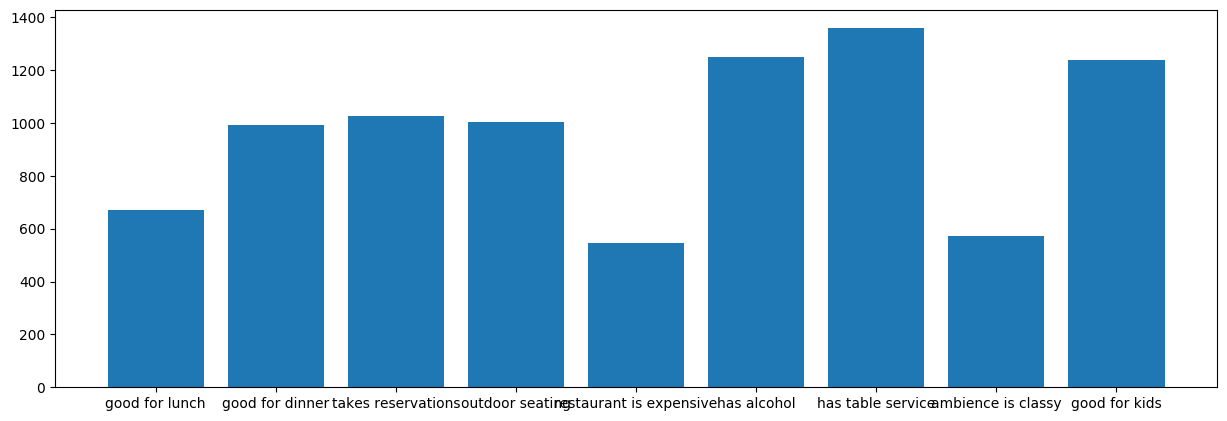

In [32]:
show_classes_count(df)

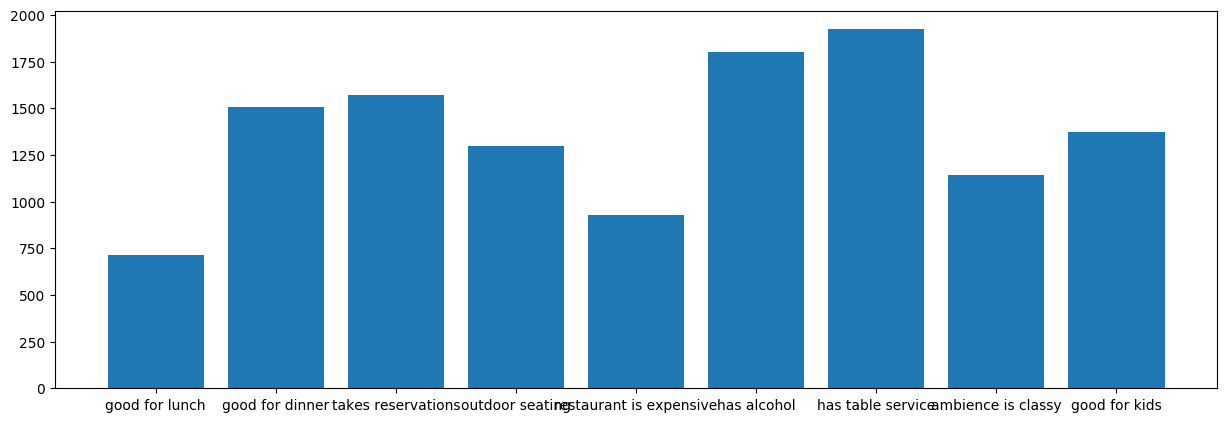

In [33]:
show_classes_count(df.append(df[df['7'] == 1]))

We can see, that it improved the situation, but we have much more samples from 5 and 6 labels comparing to 4 and 7. So let's use downsampling for 5 and 6 classes, but while removing samples take into account, that samples, that have 0, 4 and 7 classes don't remove

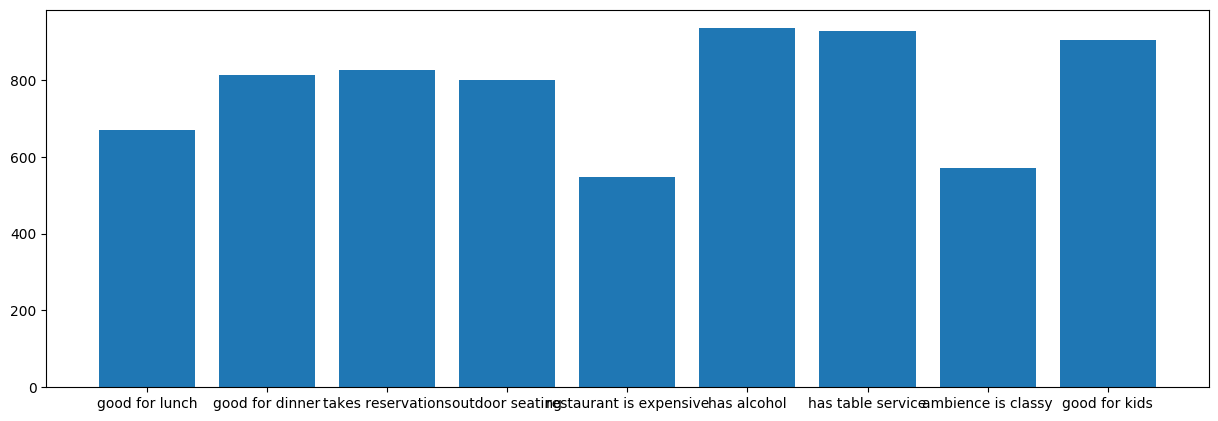

In [34]:
a = df[df['6'] == 1]
a = df[df['5'] == 1].append(a[a['5'] == 0])
a = a[a['7'] == 0]
a = a[a['4'] == 0]
a = a[a['0'] == 0]
a = df.iloc[list(set(df.index) - set(a.index))]
balanced_df = a.append(a[a['7'] == '1'])
show_classes_count(balanced_df)

For now, 7 classs could have more samples, but generally classes are much more balanced

# Classification

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import accuracy_score

In [36]:
def split_and_stratify(df, percn_to_ignore):
    y = df.drop(["photos_id", ], axis=1)
    X_stratified, _ = train_test_split(df, test_size=percn_to_ignore, random_state=42, stratify=y)
    X_stratified["photo"]
    return X_stratified

In [37]:
class BinaryRelevance:
    def __init__(self, model, label_num):
        self.models = [model() for i in range(label_num)]
        
    def fit(self, X, y):
        for ind, m in enumerate(self.models):
            m.fit(X, y.iloc[:,ind])
            
    def predict(self, X):
        res = []
        for m in self.models:
            res.append(m.predict(X))
        return np.array(res).T

In [38]:
df_train, df_test = train_test_split(balanced_df, test_size=0.2, random_state=42)
X_train = df_train.iloc[:, -2048:]
y_train = df_train.iloc[:, 1:10]
X_test = df_test.iloc[:, -2048:]
y_test = df_test.iloc[:, 1:10]

In [39]:
br = BinaryRelevance(LogisticRegression, LABELS_NUM)
br.fit(X_train, y_train)
y_pred = br.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.21498371335504887
